In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
user_df = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1')
eng_df = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])
user_df = user_df.rename({'object_id':'user_id'}, axis=1)
eng_df = eng_df.set_index('time_stamp')

In [3]:
user_df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,3/19/2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,5/21/2013 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,1/17/2013 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
eng_df.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:00,1,1
2013-11-15 03:45:00,2,1
2013-11-29 03:45:00,2,1
2013-12-09 03:45:00,2,1
2013-12-25 03:45:00,2,1


Now that we have the data loaded, we need to get these adopted users denoted in the dataset. To do this, we can resample the data set down to one day at a time, then have this rolling window that will show people who have logged on 3 days out of 7, then will give a True or False value for if that person was engaged for the required amount of time.

In [5]:
users = eng_df.user_id.unique()
adopted = []

for i in users:
    user = eng_df.user_id == i
    df_filter = eng_df[user].resample('1D').count()
    df_filter = df_filter.rolling(window=7).sum()
    df_filter = df_filter.dropna()
    adopted.append(any(df_filter["visited"].values >= 7))

Now we have all of our engaged users marked. Time to put them all in the their own DataFrame, and join that data set with the users data set. 

In [6]:
user_adoption = list(zip(users, adopted))

df_adopt = pd.DataFrame(user_adoption)
df_adopt.columns = ["user_id", "adopted_user"]

df = user_df.merge(df_adopt, on="user_id", how="left")

Making the 'adopted_user' column into ones and zeros for true and false values will allow us to do some predictive modeling on this data set.

In [7]:
df.loc[:, "adopted_user"] = df["adopted_user"].map({False:0, True:1, np.nan:0})

It will also help to know if these people were invited into the service by someone else, and can be easily done with a lambda function

In [8]:
invite = lambda row: 0 if np.isnan(row) else 1
df["invited_by_user"] = df["invited_by_user_id"].apply(invite)

Now that we have all the features and columns the way we want them, let's put all the relevant features into their own data set that we can do some modeling of.

In [9]:
df = df[["adopted_user", "invited_by_user", "creation_source", "opted_in_to_mailing_list", "enabled_for_marketing_drip"]]
df

,adopted_user,invited_by_user,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip
0,0,1,GUEST_INVITE,1,0
1,0,1,ORG_INVITE,0,0
2,0,1,ORG_INVITE,0,0
3,0,1,GUEST_INVITE,0,0
4,0,1,GUEST_INVITE,0,0
...,...,...,...,...,...
11995,0,1,ORG_INVITE,0,0
11996,0,0,SIGNUP_GOOGLE_AUTH,0,0
11997,0,1,GUEST_INVITE,1,1
11998,0,0,PERSONAL_PROJECTS,0,0


In [10]:
df.adopted_user.value_counts()

0    11379
1      621
Name: adopted_user, dtype: int64

Highly imbalanced between engaged users and non-engaged users, almost 20x. This will be a tricky problem to gain insight on. Will definitely need to use some resampling methods to get predictions on the minority class and see what's good at predicting the target variable. I will also throw in some dummy variables to gather data on that creation_source feature. I want to know what, if any, have an effect on model predictions.

I decided to use Gradient Boosting here because of the fact that each tree is not trained independently, and is instead trained off the previous one. That will lead to a more accurate model when the fitting is done than its closest competitor, Random Forest.

In [11]:
def get_classification_report(df, resample=False, resample_mult=.5):
    
    '''
    Gives a classification report on a gradient boosting model from the data set provided.
    Also has the capability of oversampling the minority class via SMOTE resampling by specifying the 'resample'
    parameter
    '''
    
    X = df.drop('adopted_user', axis=1)
    y = df['adopted_user']

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=11)
    
    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)
    
    if resample:
        sm = SMOTE(sampling_strategy={0:     y_train.value_counts().values[0], 
                                      1: int(y_train.value_counts().values[0] * resample_mult)})
        X_train, y_train = sm.fit_resample(X_train, y_train)
    
    
    steps = [('gboost', GradientBoostingClassifier(random_state=11))]
    param_grid = {'gboost__n_estimators': np.arange(10, 110, 10),
                  'gboost__max_depth':    np.arange(1, 6, 1)}

    pipeline = Pipeline(steps)
    cv = GridSearchCV(pipeline, param_grid, cv=3)
    cv.fit(X_train, y_train)
    
    y_pred = cv.predict(X_test)
    test_score = accuracy_score(y_test, y_pred)
    print(f'Model accuracy: {round(test_score*100, 2)}%')
    print(classification_report(y_test, y_pred))

In [12]:
get_classification_report(df)

Model accuracy: 94.83%
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2845
           1       0.00      0.00      0.00       155

    accuracy                           0.95      3000
   macro avg       0.47      0.50      0.49      3000
weighted avg       0.90      0.95      0.92      3000



Very good accuracy on the model. However, this problem has such an imbalance of classes that the model is just predicting that everyone is a non-adopted user and calling it good. That's not what we want. So let's do some oversampling of our under represented class so the difference isn't 28:1. First we'll do a 50% split of adopted user class to non-adopted user class.

In [13]:
get_classification_report(df, resample=True, resample_mult=.5)

Model accuracy: 94.83%
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2845
           1       0.00      0.00      0.00       155

    accuracy                           0.95      3000
   macro avg       0.47      0.50      0.49      3000
weighted avg       0.90      0.95      0.92      3000



Still not predicting our adopted user class. Let's try the sampling strategy of 75% adopted user class.

In [14]:
get_classification_report(df, resample=True, resample_mult=.75)

Model accuracy: 76.97%
              precision    recall  f1-score   support

           0       0.95      0.80      0.87      2845
           1       0.06      0.25      0.10       155

    accuracy                           0.77      3000
   macro avg       0.51      0.52      0.48      3000
weighted avg       0.91      0.77      0.83      3000



There we go, now we're getting some predictions on the adopted user class. It's bringing the accuracy of the model down, but at least we're finally getting some predictions. Let's take a look at one more test using an even split of both classes in the training data.

In [15]:
get_classification_report(df, resample=True, resample_mult=1)

Model accuracy: 48.1%
              precision    recall  f1-score   support

           0       0.96      0.47      0.63      2845
           1       0.06      0.62      0.11       155

    accuracy                           0.48      3000
   macro avg       0.51      0.55      0.37      3000
weighted avg       0.91      0.48      0.61      3000



Now we're getting somewhere. Although the accuracy of the model is below 50%, it's able to predict both classes, and has a pretty good handle on the precision of the non-adopted user class, but not really confident about the adopted user class. Very interesting result.

However, we're not just here for classification reports and accuracies. We want to know what variables have the largest effect on user retention, so let's use our 75% split case and take a look at the feature importances for that case.

In [16]:
def get_feature_importances(df):
    
    '''
    Provides the feature importances based on the model witha 75% split between majority and minority classes.
    '''
    
    X = df.drop('adopted_user', axis=1)
    y = df['adopted_user']

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=11)
    
    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)
    
    sm = SMOTE(sampling_strategy={0:     y_train.value_counts().values[0], 
                                  1: int(y_train.value_counts().values[0] * .75)})
    
    X_train, y_train = sm.fit_resample(X_train, y_train)
    
    steps = [('gboost', GradientBoostingClassifier(random_state=11))]
    param_grid = {'gboost__n_estimators': np.arange(10, 110, 10),
                  'gboost__max_depth':    np.arange(1, 6, 1)}

    pipeline = Pipeline(steps)
    cv = GridSearchCV(pipeline, param_grid, cv=3)
    cv.fit(X_train, y_train)

    pipeline.fit(X_train, y_train)
    importance = pipeline.named_steps['gboost'].feature_importances_

    feature_importance = list(zip(X_train.columns, importance))
    feature_importances = pd.DataFrame.from_records(feature_importance, columns=['Feature', 'Importance'])
    feature_importances = feature_importances.set_index('Feature').sort_values('Importance')
    print(feature_importances)
    
    plt.figure(figsize=(18,10))
    plt.barh(feature_importances.index, width=feature_importances['Importance'] * 100, color='r')
    plt.title('Gradient Boosting Feature Importances (%)')
    plt.ylabel('Feature of data set')
    plt.xlabel('Percentage Importance')
    plt.show()

                                    Importance
Feature                                       
creation_source_SIGNUP                0.000445
invited_by_user                       0.006062
creation_source_SIGNUP_GOOGLE_AUTH    0.030740
creation_source_GUEST_INVITE          0.033168
creation_source_ORG_INVITE            0.079482
opted_in_to_mailing_list              0.091894
enabled_for_marketing_drip            0.238964
creation_source_PERSONAL_PROJECTS     0.519244


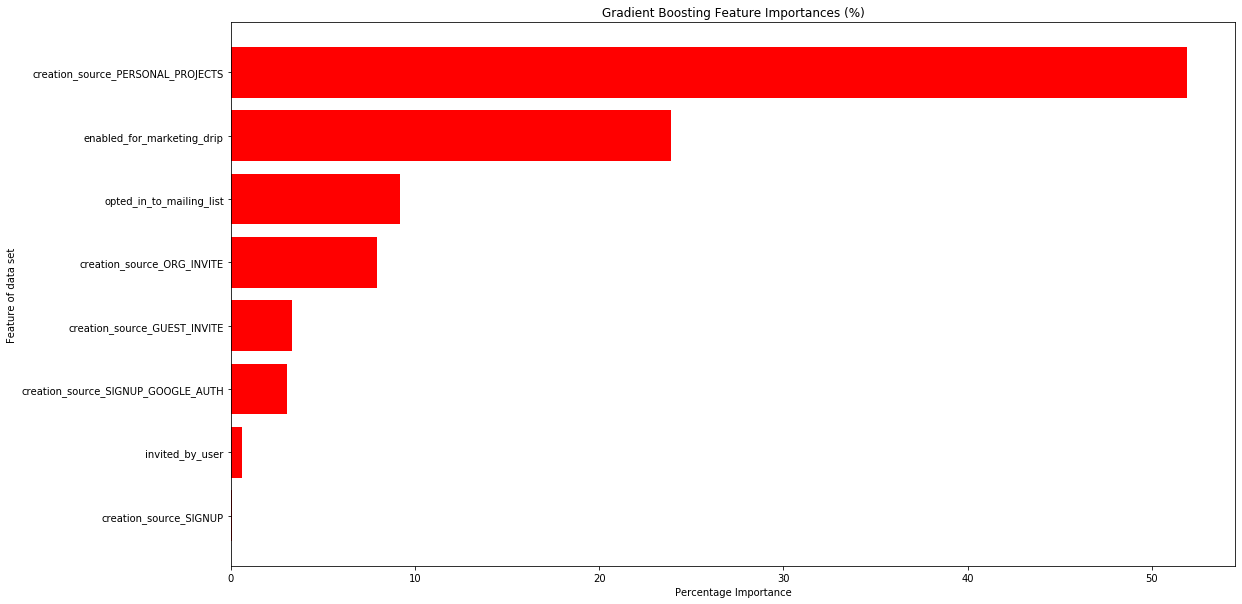

In [17]:
get_feature_importances(df)

Overall, we trained a good model for making predictions on user engagement. By taking a look at feature importances, the business can narrow down its marketing strategy and focus on what the most important features its using for getting and retaining users in the future. 

The most important feature, by a good margin, was personal projects. So people that are invited on to an already engaged user's workspace will see what it's like and if they enjoy it, sign up. Relax Inc. could find ways to incentivize engaged users to invite their colleagues and business partners onto the program.

The next most important feature in this data set was whether these people were signed up for the marketing drip. Relax could find new ways of keeping users engaged with their marketing plan which will allow for more engagement with the software overall.